In [69]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Installing Dependencies

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Loading Data

In [71]:
# 891 rows
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')

In [72]:
train_data.head()

In [73]:
# 418 rows
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.describe()

In [74]:
test_data.head()

# 2. EDA

In [75]:
train_data.columns

In [76]:
train_data.shape

In [77]:
train_data.info()

null values of columns using missingno matrix

In [78]:
msn.matrix(train_data)
plt.show()

number of null values per col

In [79]:
train_data.isnull().sum()

null values using missingno bar

In [80]:
msn.bar(train_data)
plt.show()

percentage of null values of columns

In [81]:
train_data.isnull().sum()/train_data.shape[0]

'cabin' column has many null values, hence dropping it

In [82]:
train_data.drop('Cabin', axis=1, inplace=True)

In [83]:
train_data_copy = train_data.copy()

In [84]:
# cabin dropped
train_data.head()

In [85]:
# calc null values
train_data['Age'].isnull().sum()

In [86]:
train_data.describe().T

## 2.1 Data Visualization

In [87]:
train_data['Survived'].value_counts()

Comparing % that survived wrt gender and gender_submission.csv (assumes all women survived)

74% of women survived and 19% of men died

In [88]:
# gets survival data of females (column)
women = train_data.loc[train_data.Sex == 'female']["Survived"]
# gets survival data of males (column)
men = train_data.loc[train_data.Sex == 'male']["Survived"]

# % of women that survived
percentage_women_survived = sum(women)/len(women)
# % of men that survived
percentage_men_survived = sum(men)/len(men)

print("% women survived:", percentage_women_survived)
print("% men survived:", percentage_men_survived)

In [89]:
plt.figure(figsize=(12,9))
sns.set_palette('pastel')
sns.countplot(x='Survived', hue='Sex', data=train_data)
plt.title('Death/Survival wrt Sex')
plt.show()

In [90]:
sns.set_palette('dark')
train_data['Pclass'].value_counts().plot.bar()
plt.title('Ticket class values')
plt.xlabel('Tickets')
plt.ylabel('counts')
plt.show()

In [91]:
ticket_class=train_data['Pclass'].value_counts()
print(ticket_class)

In [92]:
labels=ticket_class.index
sizes=ticket_class.values
plt.figure(figsize=(12,9))
colors=sns.color_palette('hls')
plt.pie(sizes,labels=labels,autopct='%1.1f%%',
        shadow=True,colors=colors,startangle=90)
plt.show()

Extracting Status from Name

In [93]:
status = train_data['Name'].map(lambda row: row.split(',')[1].split('.')[0])
status

In [94]:
# count of all status
statuscount = status.value_counts()
statuscount

In [95]:
# plotting status count
plt.figure(figsize=(12, 8))
sns.barplot(x=statuscount.index, y=statuscount.values)
plt.title('Number of status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [96]:
train_data['Age'].value_counts()

## 2.2 Data Cleaning

Outliers using Box plot

In [97]:
plt.figure(figsize=(12,6))
sns.boxplot(train_data['Age'])
plt.title('data with outliers')
plt.show()

In [98]:
train_data['Age'].describe()

In [99]:
train_data['Age'].median()

Remove `Age` outliers

In [100]:
def out_bound(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    return lower_bound, upper_bound

In [101]:
print(out_bound(train_data, 'Age'))

In [102]:
# skewness should be in range (-1, 1) for normal distribution
print('skewness : ', train_data.skew())

## Removing Outliers

In [103]:
def remove_outliers(df, col):
    l_b, u_b=out_bound(df, col)
    
    return df[ (df[col]>l_b) & (df[col]<u_b) ]

In [104]:
data1 = remove_outliers(train_data, 'Age')

In [105]:
plt.figure(figsize=(12,9))
sns.boxplot(data1['Age'])
plt.title('data with removed outliers')
plt.show()

## Replacing Outliers

In [106]:
def outliers_equal_bounds(df, col):
    l_b, u_b=out_bound(df, col)
    
    df.loc[(df[col]<l_b), col]=l_b
    df.loc[(df[col]>u_b), col]=u_b
    
    return df

In [107]:
data2 = outliers_equal_bounds(train_data, 'Age')

In [108]:
sns.set_palette('bright')
plt.figure(figsize=(12,9))
sns.boxplot(data2['Age'])
plt.title('Data with replaced outliers')
plt.show()

In [109]:
print('Actual Data:', train_data.shape)
print('Data w/ age outliers removed:', data1.shape)
print('Data w/ age outliers replaced:', data2.shape)

In [110]:
train_data.info()

In [111]:
sns.set_palette('dark')
plt.figure(figsize=(12,9))
sns.boxplot(x='Sex', y='Age', data=train_data_copy)
plt.title('outliers wrt sex')
plt.show()

In [112]:
train_data_copy['Embarked'].value_counts()

In [113]:
sns.set_palette('bright')
plt.figure(figsize=(12,9))
plt.title('Survival and Death wrt Port of Embarkation')
sns.countplot(x='Survived', hue='Embarked', data=train_data_copy)
plt.show()

Survival and Death wrt Embarked

In [114]:
train_data_copy.groupby('Embarked')['Survived'].value_counts()

In [115]:
train_data_copy['SibSp'].value_counts()

In [116]:
train_data_copy['Parch'].value_counts()

In [117]:
plt.figure(figsize=(12,9))
sns.countplot(x='Survived', hue='SibSp', data=train_data_copy)
plt.title('siblings survived')
plt.show()

In [118]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_palette('bright')
sns.histplot(data = train_data_copy, x='Age', ax=ax1, bins=25, hue='Survived', kde=True)
plt.title('Death and survival wrt age')
plt.show()

In [119]:
sns.set_palette('pastel')
plt.figure(figsize=(12,6))
sns.countplot(x='Survived', hue='Parch', data=train_data_copy)
plt.title('children aboard titanic')
plt.show()

In [120]:
survived = train_data['Survived'].value_counts()
print(survived)

In [121]:
labels=survived.index
sizes=survived.values
plt.figure(figsize=(12,9))
colors = sns.color_palette('Paired')
plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True,colors=colors,startangle=90)
plt.show()

In [122]:
plt.figure(figsize=(12,9))
sns.distplot(train_data['Age'])
plt.title('age density')
plt.show()

In [123]:
plt.figure(figsize=(12,7))
sns.set_palette('bright')
sns.violinplot(x=train_data['Sex'],y=train_data['Age'])
plt.title('age by gender')
plt.show()

In [124]:
sns.set_palette('dark')
plt.figure(figsize=(16,9))
sns.countplot(x='Parch', hue='Sex', data=train_data)
plt.xticks(rotation=90)
plt.show()

In [125]:
corr = train_data_copy.corr()
corr

In [126]:
plt.figure(figsize=(8,8))
plt.title('Correlation Analysis',color='Red',fontsize=20,pad=40)
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(train_data.corr(), mask=mask, annot=True, linewidths=.5);
plt.xticks(rotation=60)
plt.yticks(rotation = 60)
plt.show()

In [127]:
plt.figure(figsize=(16, 6))
sns.barplot(x=train_data['Age'].value_counts().index, y=train_data['Age'].value_counts())
plt.title('Age values')
plt.xticks(rotation=90)
plt.show()

In [128]:
plt.figure(figsize=(12,6))
sns.kdeplot(train_data[train_data['Sex']=='female']['Age'], color='purple', label='female')
sns.kdeplot(train_data[train_data['Sex']=='male']['Age'], color='orange', label='male')
plt.title('Ages by gender density')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [129]:
sns.pairplot(train_data, hue = 'Survived')

In [130]:
numerical = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

categories = ['Sex', 'Embarked']

In [131]:
fig, ax = plt.subplots(2,3, figsize = (20,10))

for variable, subplot in zip(numerical, ax.flatten()):
    
    sns.histplot(train_data[variable],kde = True, ax = subplot)

In [132]:
fig, ax = plt.subplots(1,2, figsize = (20, 10))

for variable, subplot in zip(categories, ax.flatten()):
    
    sns.countplot(x = variable, ax = subplot, hue = 'Survived', data = train_data)

In [133]:
fig, ax = plt.subplots(2,3, figsize = (30, 20))

for variable, subplots in zip(numerical, ax.flatten()):
    
    sns.histplot(x = variable, data = train_data, hue = 'Survived',kde = True, ax = subplots)

## Conclusion from Above plots

1. Pclass 3 has low survival rate

2. age b/w 20 and 50 have more values and lesser survival rate than other age groups

3. SibSp (Sibling and spouses) 0 and Parch (Parents and child) 0 have greater count but low survival rate

4. SibSp, Parch, Fare and Age have outliers

# 3. **Random Forest Model**
With 100 Trees, Output is taken as the avg of predictions

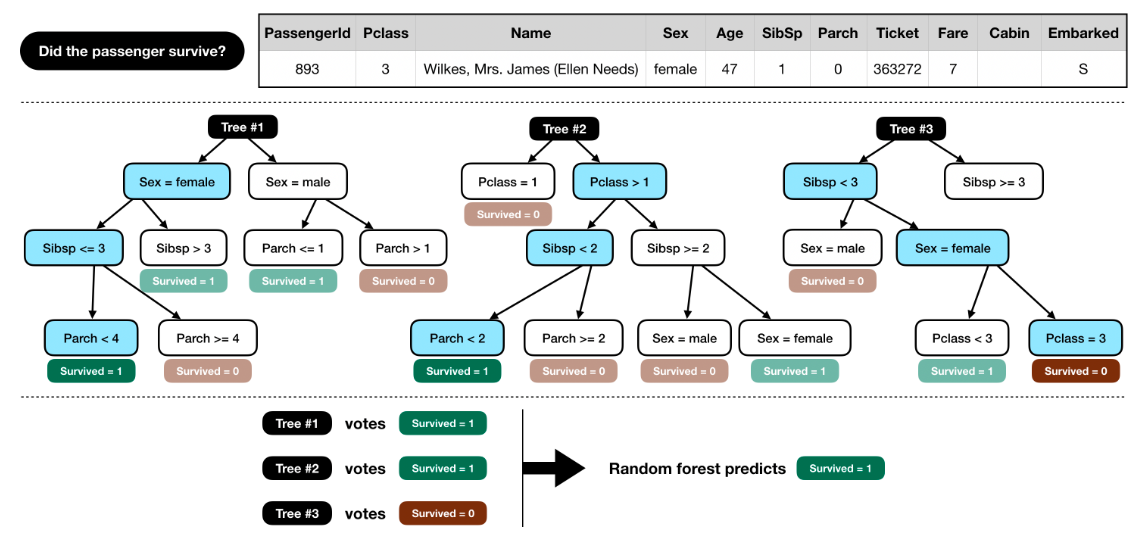

cell below looks for patterns in columns ["Pclass", "Sex", "SibSp", and "Parch"] of data. Constructs trees in random forest model based on patterns in the train.csv file, b4 generating predictions for passengers in test.csv. 

Code saves new predictions in a CSV file **rf_submission.csv.**

In [134]:
from sklearn.ensemble import RandomForestClassifier

y = train_data['Survived']

features = ["Pclass", "Sex", "SibSp", "Parch"]
# converts categorical data into dummy/indicator data 
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

# maximum depth of tree = 5
# number of trees = 100
# defining model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# fitting model
model.fit(X, y)
# predicting on test data
predictions = model.predict(X_test)

In [135]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('rf_submission.csv', index = False)
print("Your submission was successfully saved!")

---